Implementation of GAN training framework for MNIST dataset using CNN generator and discriminator.
##[Paper](https://arxiv.org/pdf/1406.2661.pdf)

In [ ]:
import time
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from sklearn.metrics import accuracy_score
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid, save_image

# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {device}")

Using cuda:0


In [ ]:
train_images = MNIST(
    "", train=True, transform=transforms.ToTensor(), download=True
)  # 28x28 size

BATCH_SIZE = 32  # Size of minibatches
LATENT_DIM = 50  # Dimension size for the random noise Z
INITIAL_MAP_SIZE = (
    7  # Dimension size for the initial SxS images generated from the noise
)


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
### GENERATOR

class UpSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSampleConv, self).__init__()
        self.up = nn.Upsample(scale_factor=2)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.conv = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1
        )

    def forward(self, x):
        out = self.up(x)
        out = self.conv(out)
        out = self.batch_norm(out)
        out = F.relu(out)
        return out


class GenModel(nn.Module):
    def __init__(
        self, initial_channels=64, latent_dim=LATENT_DIM, initial_map=INITIAL_MAP_SIZE
    ):
        super(GenModel, self).__init__()
        self.initial_map_size = initial_map
        self.initial_channels = initial_channels
        self.linear = nn.Linear(
            in_features=latent_dim,
            out_features=initial_channels * initial_map * initial_map,
        )
        self.upsample = nn.Sequential(
            UpSampleConv(in_channels=initial_channels, out_channels=initial_channels),
            UpSampleConv(in_channels=initial_channels, out_channels=1),
        )

    def forward(self, x):
        result = F.relu(self.linear(x))
        result = result.view(
            -1, self.initial_channels, self.initial_map_size, self.initial_map_size
        )

        result = self.upsample(result).squeeze(dim=1)

        return result


### DISCRIMINATOR

class DiscModel(nn.Module):
    def __init__(self, in_channels=1, out_classes=2):
        super(DiscModel, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=16, kernel_size=3, padding=1
        )
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.output = nn.Linear(in_features=8 * 7 * 7, out_features=out_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = F.leaky_relu(self.pool(out), 0.2)

        out = self.conv2(out)
        out = F.leaky_relu(self.pool(out), 0.2)

        out = out.flatten(1)

        return self.output(out)

In [ ]:
def adversarial_train(
    generator,
    discriminator,
    gen_optim,
    disc_optim,
    data_loader,
    loss_function,
    latent_dim=LATENT_DIM,
    batch_size=BATCH_SIZE,
    epochs=50,
):
    real_label = torch.ones(batch_size).long().to(device)
    fake_label = torch.zeros(batch_size).long().to(device)

    evaluation_noise = torch.normal(mean=0, std=1, size=(100, latent_dim)).to(device)

    gen_losses = []
    accuracies = []
    disc_fake_losses = []
    disc_valid_losses = []

    for current_epoch in range(epochs):
        start = time.time()

        gen_loss = 0
        disc_loss_valid = 0
        disc_loss_fake = 0
        all_predictions = []

        for real_images, _ in data_loader:
            ##  Train Discriminator ##
            disc_optim.zero_grad()

            # All-real batch
            disc_real_cost = loss_function(
                discriminator(real_images.to(device)), real_label
            )
            disc_loss_valid += disc_real_cost.item()

            # All-fake batch
            noise = torch.normal(mean=0, std=1, size=(batch_size, latent_dim)).to(
                device
            )
            gen_images = generator(noise)
            fake_data_predictions = discriminator(gen_images.unsqueeze(1))
            disc_fake_cost = loss_function(fake_data_predictions, fake_label)
            disc_loss_fake += disc_fake_cost.item()

            disc_total_cost = disc_real_cost + disc_fake_cost
            disc_total_cost.backward()
            disc_optim.step()

            ## Train Generator ##
            gen_optim.zero_grad()
            noise = torch.normal(mean=0, std=1, size=(batch_size, latent_dim)).to(
                device
            )
            gen_images = generator(noise)

            # Measure ability of generator to FOOL discriminator
            fake_data_predictions = discriminator(gen_images.unsqueeze(1))
            gen_cost = loss_function(fake_data_predictions, real_label)
            gen_loss += gen_cost.item()

            gen_cost.backward()
            gen_optim.step()

            all_predictions.extend(
                torch.argmax(fake_data_predictions, dim=1).cpu().numpy()
            )

        gen_losses.append(gen_loss / len(data_loader))
        disc_fake_losses.append(disc_loss_fake / len(data_loader))
        disc_valid_losses.append(disc_loss_valid / len(data_loader))

        gen_images = generator(evaluation_noise)
        grid = make_grid(gen_images.unsqueeze(1))
        save_image(grid, f"sample_data/{current_epoch + 1}.png")

        disc_fake_accuracy = accuracy_score(
            np.zeros(len(all_predictions)), all_predictions
        )
        accuracies.append(disc_fake_accuracy)

        print(
            f"Epoch {current_epoch + 1} | "
            f"Accuracy {disc_fake_accuracy:.2f} | "
            f"Gen Loss {(gen_loss / len(data_loader)):.6f} | "
            f"Disc Fake Loss {(disc_loss_fake / len(data_loader)):.6f} | "
            f"Disc Valid Loss {(disc_loss_valid / len(data_loader)):.6f}| "
            f"Time {(time.time() - start):.2f} sec"
        )
    return gen_losses, disc_fake_losses, disc_valid_losses, accuracies

In [ ]:
train_dataloader = DataLoader(
    train_images, batch_size=BATCH_SIZE, num_workers=8, pin_memory=True
)

generator = GenModel(latent_dim=LATENT_DIM).to(device)
discriminator = DiscModel(in_channels=1).to(device)

gen_optim = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
disc_optim = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

cost_function = nn.CrossEntropyLoss().to(device)

Epoch 1 | Accuracy 0.79 | Gen Loss 0.951759 | Disc Fake Loss 0.561064 | Disc Valid Loss 0.588551| Time 23.42 sec
Epoch 2 | Accuracy 0.91 | Gen Loss 0.938382 | Disc Fake Loss 0.522669 | Disc Valid Loss 0.532721| Time 23.34 sec
Epoch 3 | Accuracy 0.87 | Gen Loss 1.061251 | Disc Fake Loss 0.475363 | Disc Valid Loss 0.486947| Time 23.10 sec
Epoch 4 | Accuracy 0.77 | Gen Loss 0.975946 | Disc Fake Loss 0.542248 | Disc Valid Loss 0.554638| Time 23.04 sec
Epoch 5 | Accuracy 0.71 | Gen Loss 0.919295 | Disc Fake Loss 0.587408 | Disc Valid Loss 0.604218| Time 23.91 sec
Epoch 6 | Accuracy 0.69 | Gen Loss 0.881788 | Disc Fake Loss 0.602111 | Disc Valid Loss 0.622538| Time 24.11 sec
Epoch 7 | Accuracy 0.66 | Gen Loss 0.846382 | Disc Fake Loss 0.621071 | Disc Valid Loss 0.641835| Time 23.83 sec
Epoch 8 | Accuracy 0.63 | Gen Loss 0.813638 | Disc Fake Loss 0.643370 | Disc Valid Loss 0.661127| Time 23.02 sec
Epoch 9 | Accuracy 0.63 | Gen Loss 0.796857 | Disc Fake Loss 0.648056 | Disc Valid Loss 0.663513

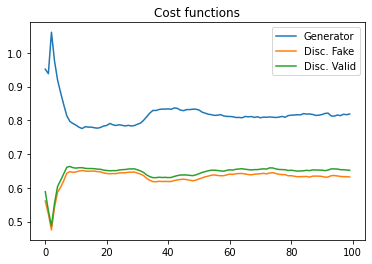

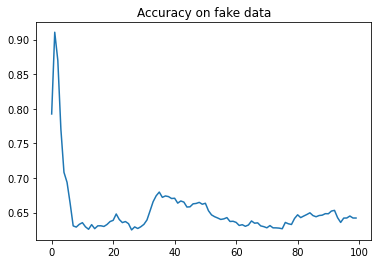

In [ ]:
N_EPOCHS = 100

gen_losses, disc_fake_losses, disc_valid_losses, accuracies = adversarial_train(
    generator,
    discriminator,
    gen_optim,
    disc_optim,
    train_dataloader,
    cost_function,
    epochs=N_EPOCHS,
)

plt.plot(range(N_EPOCHS), gen_losses, label="Generator")
plt.plot(range(N_EPOCHS), disc_fake_losses, label="Disc. Fake")
plt.plot(range(N_EPOCHS), disc_valid_losses, label="Disc. Valid")
plt.legend()
plt.title("Cost functions")
plt.show()

plt.plot(range(N_EPOCHS), accuracies)
plt.title("Accuracy on fake data")
plt.show()

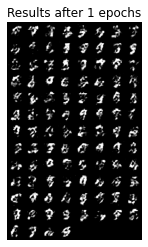

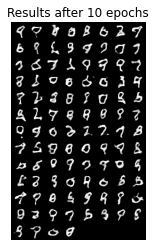

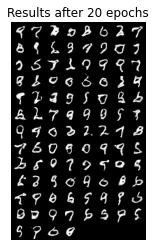

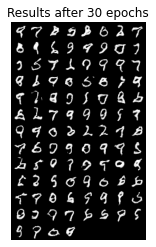

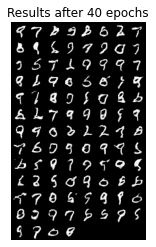

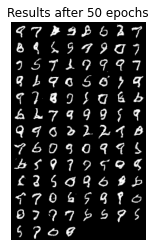

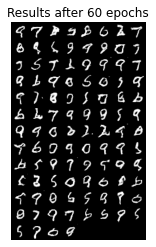

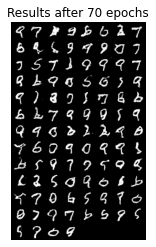

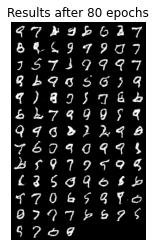

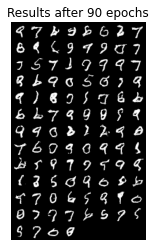

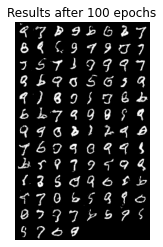

In [ ]:
image = Image.open(f"sample_data/1.png")
plt.imshow(image)
plt.title(f"Results after 1 epochs")
plt.axis("off")
plt.show()

for i in range(10, N_EPOCHS + 1, 10):
    image = Image.open(f"sample_data/{i}.png")
    plt.imshow(image)
    plt.title(f"Results after {i} epochs")
    plt.axis("off")
    plt.show()